<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/Seq2SeqMath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq

![](https://www.guru99.com/images/1/111318_0848_seq2seqSequ3.png)

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Bidirectional
from keras.callbacks import Callback

from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
TRAINING_SIZE = 50000
DIGITS = 3
MAXLEN = DIGITS + 1 + DIGITS

# Data
* Adapted from https://keras.io/examples/nlp/addition_rnn

In [3]:
class CharacterTable:
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """

    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)


# All the numbers, plus sign and space for padding.
chars = "0123456789+ "
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print("Generating data...")
while len(questions) < TRAINING_SIZE:
    f = lambda: int(
        "".join(
            np.random.choice(list("0123456789"))
            for i in range(np.random.randint(1, DIGITS + 1))
        )
    )
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = "{}+{}".format(a, b)
    query = q + " " * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += " " * (DIGITS + 1 - len(ans))

    questions.append(query)
    expected.append(ans)
print("Total questions:", len(questions))

Generating data...
Total questions: 50000


In [4]:
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, MAXLEN)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

Training Data:
(45000, 7, 12)
(45000, 7, 12)
Validation Data:
(5000, 7, 12)
(5000, 7, 12)


## Examples

In [5]:
x_train[0]

array([[False, False, False, False, False, False, False, False, False,
        False, False,  True],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
         True, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False]])

In [6]:
x_train[0].astype('int')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [7]:
ctable.decode(x_train[0])

'993+70 '

y_train[0].astype('int')

In [8]:
ctable.decode(y_train[0])

'1063   '

# Results
* Compare accuracy of model
* Compare complexity and time to train

In [9]:
results_df = pd.DataFrame(columns=['Accuracy', 'Time', 'Parameters'])

# Parameters
* Fix number of epochs and batch size


In [10]:
EPOCHS     = 10
BATCH_SIZE = 32

# Helpers
* Helper to plot random random examples and accuracy
* Plotting history object

In [11]:
class PrintExamples(Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(' ')
    for i in range(10):
      ind        = np.random.randint(0, len(x))
      rowx, rowy = x[np.array([ind])], y[np.array([ind])]
      preds      = np.argmax(model.predict(rowx), axis=-1)

      q       = ctable.decode(rowx[0])
      correct = ctable.decode(rowy[0])
      guess   = ctable.decode(preds[0], calc_argmax=False)
      print(f'  Q {q} = {correct} {"☑ " if correct == guess else "☒ "} {guess}')

In [12]:
def plot_performance(history, color_train='blue', color_val='red'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# LSTM

## Base

In [13]:
model = Sequential()
# Encoder
#  - Encode the input using a LSTM
#  - The output of the LSTM represents the "thought vector"
#  - In this example the size is 128
#  - We can have a purely variable output not specifying max length
model.add(LSTM(128, input_shape=(MAXLEN, len(chars))))

# Decoder
#  - For input to the decoder, we repeat the output of the encoder at each time step
#  - We decode by passing the context vector through a LSTM
#  - The LSTM receives the "thought vector" and is aware of its own state
model.add(RepeatVector(MAXLEN))
model.add(LSTM(128, return_sequences=True))

# Output
#  - We use a dense layer with softmax
#  - Softmax indicates the item in the vocabulary we show in the output
model.add(Dense(len(chars), activation="softmax"))

# Compilation
#  - Our loss function is categorical_crossentropy
#  - We use Adam optimizer (default learning rate)
#  - Use accuracy as a metric for output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dense (Dense)                (None, 7, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


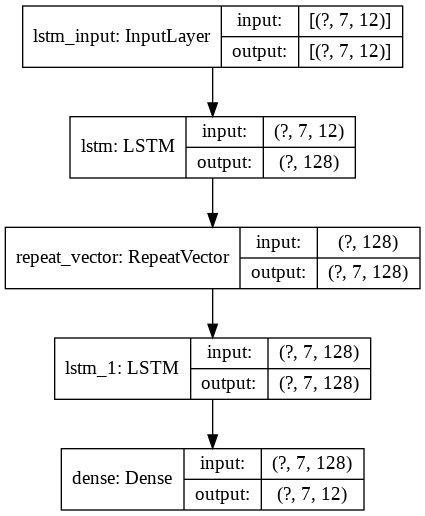

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
start = datetime.datetime.now()
history_base_lstm = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[PrintExamples()])
end = datetime.datetime.now()

Epoch 1/10
1405/1407 [============================>.] - ETA: 0s - loss: 1.0107 - accuracy: 0.6298 
  Q 20+977  = 997     ☒  101    
  Q 205+619 = 824     ☒  699    
  Q 56+440  = 496     ☒  591    
  Q 3+547   = 550     ☒  508    
  Q 562+22  = 584     ☒  681    
  Q 393+345 = 738     ☒  709    
  Q 845+28  = 873     ☒  591    
  Q 460+91  = 551     ☒  603    
  Q 70+482  = 552     ☒  891    
  Q 158+7   = 165     ☒  11     
1407/1407 [==============================] - 11s 7ms/step - loss: 1.0106 - accuracy: 0.6298 - val_loss: 0.8899 - val_accuracy: 0.6648
Epoch 2/10
1407/1407 [==============================] - ETA: 0s - loss: 0.7801 - accuracy: 0.7038 
  Q 1+508   = 509     ☒  510    
  Q 140+489 = 629     ☒  617    
  Q 74+919  = 993     ☒  977    
  Q 464+59  = 523     ☒  537    
  Q 631+693 = 1324    ☒  1303   
  Q 963+4   = 967     ☒  968    
  Q 85+261  = 346     ☑  346    
  Q 366+90  = 456     ☒  436    
  Q 401+3   = 404     ☒  415    
  Q 165+63  = 228     ☒  247    
1407/140

In [16]:
time = (end - start).total_seconds() 
pred = model.predict(x_val)
acc  = accuracy_score(
        np.argmax(pred,  axis=2).reshape(-1),
        np.argmax(y_val, axis=2).reshape(-1))
results_df.loc['LSTM'] = [acc, time, model.count_params()]

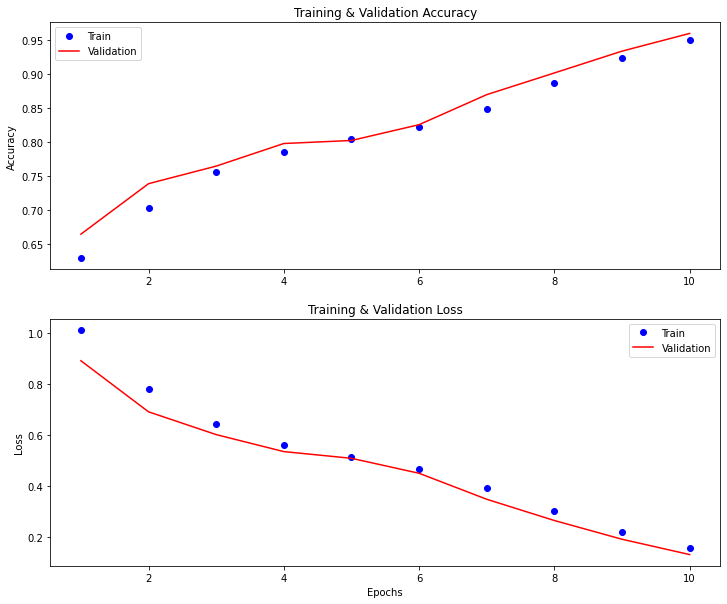

In [17]:
plot_performance(history_base_lstm)

## Deep

![](https://i.stack.imgur.com/3Lh2p.jpg)

In [18]:
model = Sequential()
# Encoder
#  - Encode the input using a LSTM
#  - The output of the LSTM represents the "thought vector"
#  - In this example the size is 128
#  - We can have a purely variable output not specifying max length
model.add(LSTM(128, input_shape=(MAXLEN, len(chars))))

# Decoder
#  - For input to the decoder, we repeat the output of the encoder at each time step
#  - We decode by passing the context vector through two LSTM layers
#  - The LSTM receives the "thought vector" and is aware of its own state
model.add(RepeatVector(MAXLEN))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))

# Output
#  - We use a dense layer with softmax
#  - Softmax indicates the item in the vocabulary we show in the output
model.add(Dense(len(chars), activation="softmax"))

# Compilation
#  - Our loss function is categorical_crossentropy
#  - We use Adam optimizer (default learning rate)
#  - Use accuracy as a metric for output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dense_1 (Dense)              (None, 7, 12)             1548      
Total params: 336,908
Trainable params: 336,908
Non-trainable params: 0
_________________________________________________________________


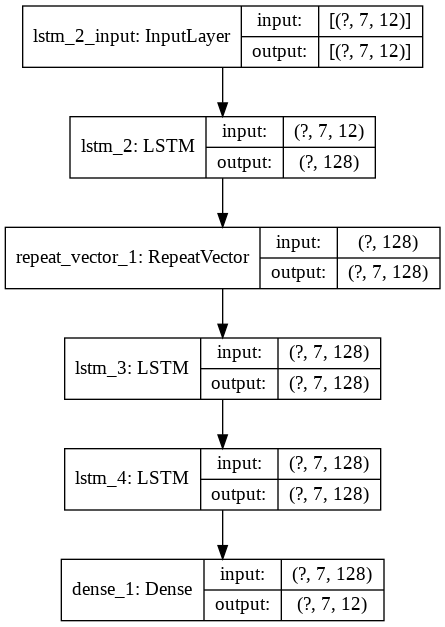

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
start = datetime.datetime.now()
history_deep_lstm = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[PrintExamples()])
end = datetime.datetime.now()

Epoch 1/10
1402/1407 [============================>.] - ETA: 0s - loss: 1.0115 - accuracy: 0.6269 
  Q 44+633  = 677     ☒  796    
  Q 36+368  = 404     ☒  396    
  Q 804+498 = 1302    ☒  1066   
  Q 88+584  = 672     ☒  766    
  Q 39+299  = 338     ☒  216    
  Q 156+77  = 233     ☒  396    
  Q 111+32  = 143     ☒  216    
  Q 323+119 = 442     ☒  696    
  Q 0+53    = 53      ☒  11     
  Q 753+779 = 1532    ☒  1466   
1407/1407 [==============================] - 13s 10ms/step - loss: 1.0112 - accuracy: 0.6269 - val_loss: 0.8938 - val_accuracy: 0.6600
Epoch 2/10
1402/1407 [============================>.] - ETA: 0s - loss: 0.7843 - accuracy: 0.6997 
  Q 3+193   = 196     ☒  111    
  Q 521+90  = 611     ☒  622    
  Q 811+621 = 1432    ☒  1331   
  Q 57+53   = 110     ☒  113    
  Q 488+67  = 555     ☒  552    
  Q 47+708  = 755     ☒  722    
  Q 441+90  = 531     ☒  512    
  Q 56+489  = 545     ☒  522    
  Q 947+289 = 1236    ☒  1111   
  Q 233+915 = 1148    ☒  1111   
1407/14

In [21]:
time = (end - start).total_seconds() 
pred = model.predict(x_val)
acc  = accuracy_score(
        np.argmax(pred,  axis=2).reshape(-1),
        np.argmax(y_val, axis=2).reshape(-1))
results_df.loc['LSTM DEEP'] = [acc, time, model.count_params()]

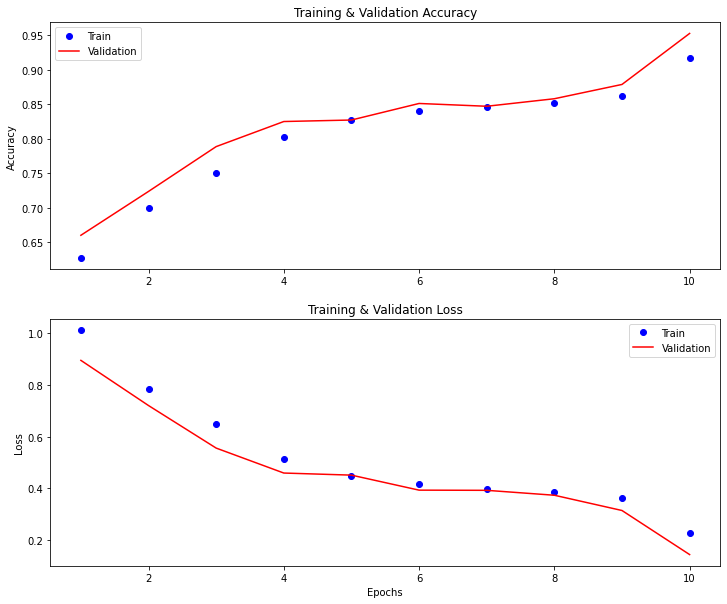

In [22]:
plot_performance(history_deep_lstm)

## Bidirectional

![](https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

In [23]:
model = Sequential()
# Encoder
#  - Encode the input using a LSTM
#  - We allow the encoder to look forward and backwards
#  - We do need to decide how to "combine"
#    - Default is concat
#    - Other options sum, mul, ave
#  - The output of the LSTM represents the "thought vector"
#  - In this example the size is 128
#  - We can have a purely variable output not specifying max length
model.add(Bidirectional(LSTM(128), input_shape=(MAXLEN, len(chars))))

# Decoder
#  - For input to the decoder, we repeat the output of the encoder at each time step
#  - We decode by passing the context vector through the LSTM layer
#  - The LSTM receives the "thought vector" and is aware of its own state
model.add(RepeatVector(MAXLEN))
model.add(LSTM(128, return_sequences=True))

# Output
#  - We use a dense layer with softmax
#  - Softmax indicates the item in the vocabulary we show in the output
model.add(Dense(len(chars), activation="softmax"))

# Compilation
#  - Our loss function is categorical_crossentropy
#  - We use Adam optimizer (default learning rate)
#  - Use accuracy as a metric for output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               144384    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 128)            197120    
_________________________________________________________________
dense_2 (Dense)              (None, 7, 12)             1548      
Total params: 343,052
Trainable params: 343,052
Non-trainable params: 0
_________________________________________________________________


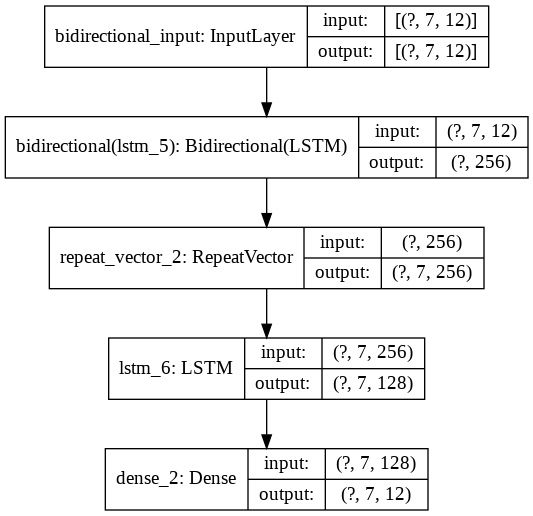

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
start = datetime.datetime.now()
history_bidi_lstm = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[PrintExamples()])
end = datetime.datetime.now()

Epoch 1/10
1404/1407 [============================>.] - ETA: 0s - loss: 0.9668 - accuracy: 0.6399 
  Q 858+51  = 909     ☒  902    
  Q 98+709  = 807     ☒  804    
  Q 21+400  = 421     ☒  411    
  Q 92+640  = 732     ☒  772    
  Q 901+948 = 1849    ☒  1777881
  Q 865+219 = 1084    ☒  1142   
  Q 109+93  = 202     ☒  210    
  Q 96+31   = 127     ☒  100    
  Q 560+555 = 1115    ☒  1120   
  Q 212+513 = 725     ☒  744    
1407/1407 [==============================] - 14s 10ms/step - loss: 0.9665 - accuracy: 0.6399 - val_loss: 0.8120 - val_accuracy: 0.6719
Epoch 2/10
1403/1407 [============================>.] - ETA: 0s - loss: 0.7244 - accuracy: 0.6969 
  Q 865+426 = 1291    ☒  127188 
  Q 952+37  = 989     ☒  978    
  Q 91+895  = 986     ☒  971    
  Q 115+7   = 122     ☒  117    
  Q 87+46   = 133     ☒  122    
  Q 818+724 = 1542    ☒  1572889
  Q 727+329 = 1056    ☒  1078   
  Q 167+325 = 492     ☒  478    
  Q 545+668 = 1213    ☒  122228 
  Q 39+859  = 898     ☒  978    
1407/14

In [26]:
time = (end - start).total_seconds() 
pred = model.predict(x_val)
acc  = accuracy_score(
        np.argmax(pred,  axis=2).reshape(-1),
        np.argmax(y_val, axis=2).reshape(-1))
results_df.loc['LSTM BIDI'] = [acc, time, model.count_params()]

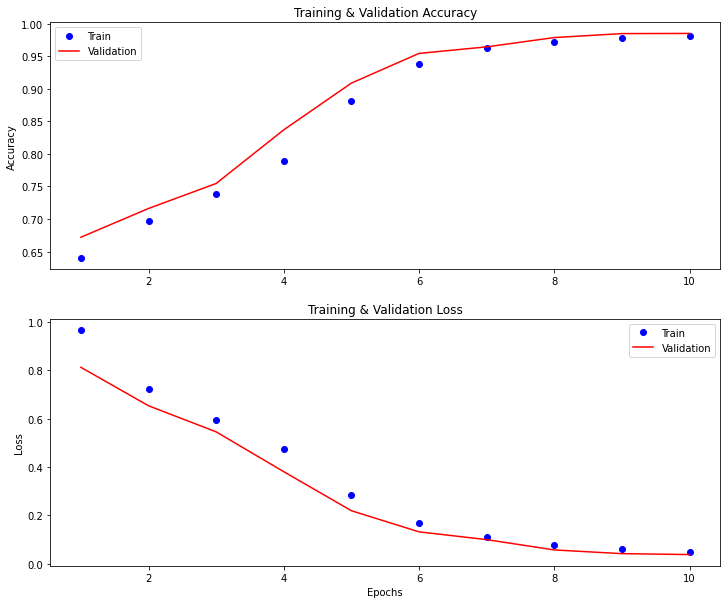

In [27]:
plot_performance(history_bidi_lstm)

# GRU
![](https://ahmedabadmirror.indiatimes.com/thumb/64033616.cms?resizemode=4&width=400)

![](https://cdn.shortpixel.ai/client/q_glossy,ret_img,w_1200/http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1200x361.png)

* GRU is a variation of the LSTM 
* Like the LSTM it's able to solve the vanishing gradient problem
  * Fewer parameters
  * Fewer computations
* Uses an update gate and a reset gate
* Update gate controls what that flows into memory
* Reset gate controls what flows out of memory
* Each gate is a matrix of weights that decide what to pass to the output
* Through back propagation, we "learn" to keep or drop information relevant to the prediction (how to minimize loss)

## Base

In [28]:
model = Sequential()
# Encoder
#  - Encode the input using a GRU
#  - The output of the GRU represents the "thought vector"
#  - In this example the size is 128
#  - We can have a purely variable output not specifying max length
model.add(GRU(128, input_shape=(MAXLEN, len(chars))))

# Decoder
#  - For input to the decoder, we repeat the output of the encoder at each time step
#  - We decode by passing the context vector through a GRU
#  - The GRU receives the "thought vector" and is aware of its own state
model.add(RepeatVector(MAXLEN))
model.add(GRU(128, return_sequences=True))

# Output
#  - We use a dense layer with softmax
#  - Softmax indicates the item in the vocabulary we show in the output
model.add(Dense(len(chars), activation="softmax"))

# Compilation
#  - Our loss function is categorical_crossentropy
#  - We use Adam optimizer (default learning rate)
#  - Use accuracy as a metric for output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               54528     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 7, 128)            99072     
_________________________________________________________________
dense_3 (Dense)              (None, 7, 12)             1548      
Total params: 155,148
Trainable params: 155,148
Non-trainable params: 0
_________________________________________________________________


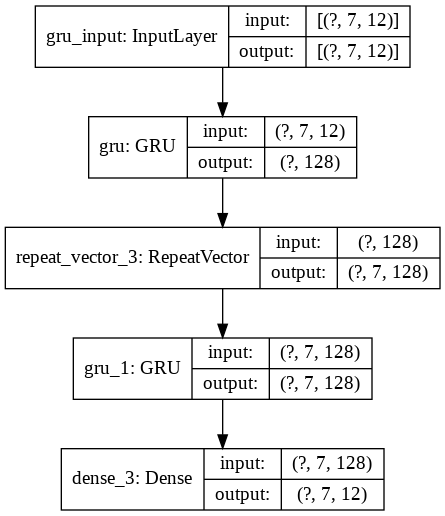

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [30]:
start = datetime.datetime.now()
history_base_gru = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[PrintExamples()])
end = datetime.datetime.now()

Epoch 1/10
1406/1407 [============================>.] - ETA: 0s - loss: 0.9565 - accuracy: 0.6451 
  Q 5+717   = 722     ☒  740    
  Q 375+92  = 467     ☒  437    
  Q 153+38  = 191     ☒  110    
  Q 492+0   = 492     ☒  450    
  Q 934+45  = 979     ☒  907    
  Q 642+45  = 687     ☒  670    
  Q 579+208 = 787     ☒  900    
  Q 5+624   = 629     ☒  600    
  Q 375+595 = 970     ☒  107    
  Q 65+207  = 272     ☒  370    
1407/1407 [==============================] - 10s 7ms/step - loss: 0.9565 - accuracy: 0.6451 - val_loss: 0.7791 - val_accuracy: 0.7122
Epoch 2/10
1403/1407 [============================>.] - ETA: 0s - loss: 0.7239 - accuracy: 0.7239 
  Q 272+4   = 276     ☒  264    
  Q 813+4   = 817     ☒  822    
  Q 34+26   = 60      ☒  66     
  Q 4+462   = 466     ☒  444    
  Q 71+221  = 292     ☒  306    
  Q 874+56  = 930     ☒  921    
  Q 86+593  = 679     ☒  656    
  Q 703+989 = 1692    ☒  1612   
  Q 201+26  = 227     ☒  264    
  Q 71+465  = 536     ☒  545    
1407/140

In [31]:
time = (end - start).total_seconds() 
pred = model.predict(x_val)
acc  = accuracy_score(
        np.argmax(pred,  axis=2).reshape(-1),
        np.argmax(y_val, axis=2).reshape(-1))
results_df.loc['GRU'] = [acc, time, model.count_params()]

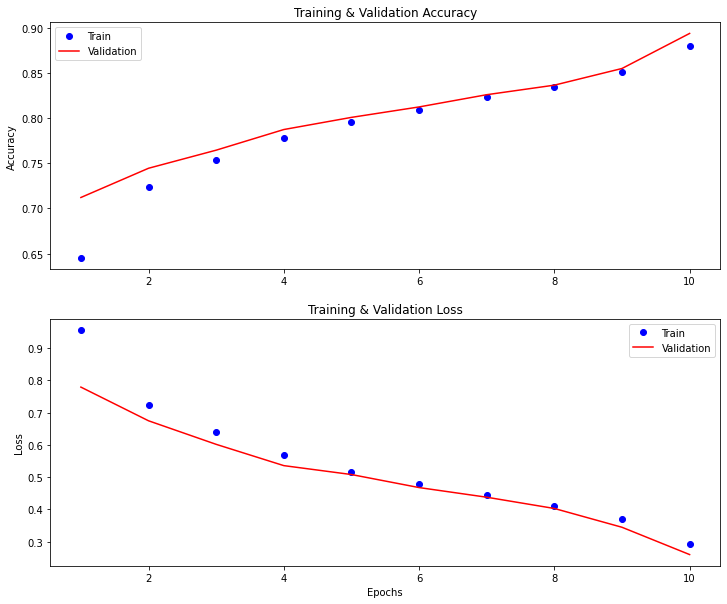

In [32]:
plot_performance(history_base_gru)

## Deep

In [33]:
model = Sequential()
# Encoder
#  - Encode the input using a GRU
#  - The output of the GRU represents the "thought vector"
#  - In this example the size is 128
#  - We can have a purely variable output not specifying max length
model.add(GRU(128, input_shape=(MAXLEN, len(chars))))

# Decoder
#  - For input to the decoder, we repeat the output of the encoder at each time step
#  - We decode by passing the context vector through two GRU layers
#  - The GRU receives the "thought vector" and is aware of its own state
model.add(RepeatVector(MAXLEN))
model.add(GRU(128, return_sequences=True))
model.add(GRU(128, return_sequences=True))

# Output
#  - We use a dense layer with softmax
#  - Softmax indicates the item in the vocabulary we show in the output
model.add(Dense(len(chars), activation="softmax"))

# Compilation
#  - Our loss function is categorical_crossentropy
#  - We use Adam optimizer (default learning rate)
#  - Use accuracy as a metric for output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 128)               54528     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 7, 128)            99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 7, 128)            99072     
_________________________________________________________________
dense_4 (Dense)              (None, 7, 12)             1548      
Total params: 254,220
Trainable params: 254,220
Non-trainable params: 0
_________________________________________________________________


In [34]:
start = datetime.datetime.now()
history_deep_gru = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[PrintExamples()])
end = datetime.datetime.now()

Epoch 1/10
1401/1407 [============================>.] - ETA: 0s - loss: 0.9362 - accuracy: 0.6488 
  Q 573+3   = 576     ☒  666    
  Q 53+991  = 1044    ☒  1022   
  Q 38+511  = 549     ☒  566    
  Q 3+304   = 307     ☒  366    
  Q 899+473 = 1372    ☒  1376   
  Q 643+325 = 968     ☒  106    
  Q 861+545 = 1406    ☒  1416   
  Q 13+443  = 456     ☒  461    
  Q 16+65   = 81      ☒  70     
  Q 468+57  = 525     ☒  526    
1407/1407 [==============================] - 12s 9ms/step - loss: 0.9356 - accuracy: 0.6490 - val_loss: 0.7512 - val_accuracy: 0.7135
Epoch 2/10
1405/1407 [============================>.] - ETA: 0s - loss: 0.7081 - accuracy: 0.7298 
  Q 771+6   = 777     ☒  796    
  Q 634+753 = 1387    ☒  1366   
  Q 500+282 = 782     ☒  706    
  Q 23+948  = 971     ☒  955    
  Q 94+43   = 137     ☒  133    
  Q 619+61  = 680     ☒  766    
  Q 72+696  = 768     ☒  796    
  Q 277+491 = 768     ☒  706    
  Q 143+710 = 853     ☒  836    
  Q 918+87  = 1005    ☒  1022   
1407/140

In [35]:
time = (end - start).total_seconds() 
pred = model.predict(x_val)
acc  = accuracy_score(
        np.argmax(pred,  axis=2).reshape(-1),
        np.argmax(y_val, axis=2).reshape(-1))
results_df.loc['GRU DEEP'] = [acc, time, model.count_params()]

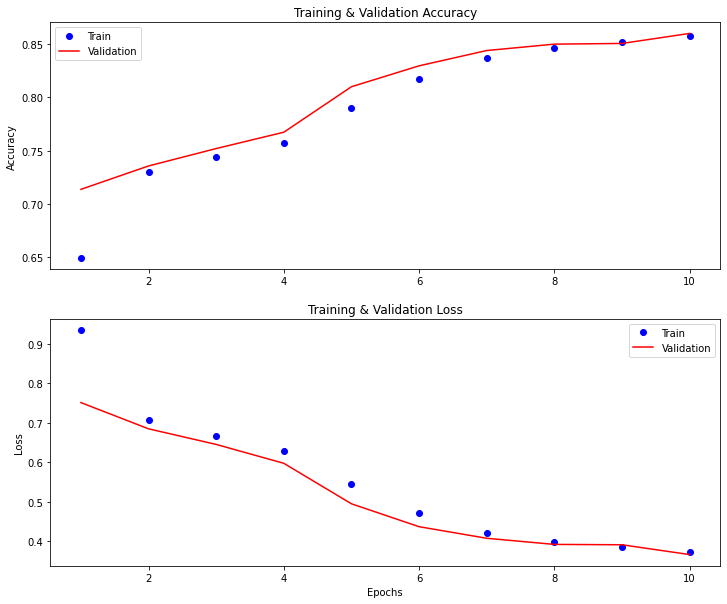

In [36]:
plot_performance(history_deep_gru)

## Bidirectional

In [37]:
model = Sequential()
# Encoder
#  - Encode the input using a GRU
#  - We allow the encoder to look forward and backwards
#  - We do need to decide how to "combine"
#    - Default is concat
#    - Other options sum, mul, ave
#  - The output of the GRU represents the "thought vector"
#  - In this example the size is 128
#  - We can have a purely variable output not specifying max length
model.add(Bidirectional(GRU(128), input_shape=(MAXLEN, len(chars))))

# Decoder
#  - For input to the decoder, we repeat the output of the encoder at each time step
#  - We decode by passing the context vector through the GRU layer
#  - The GRU receives the "thought vector" and is aware of its own state
model.add(RepeatVector(MAXLEN))
model.add(GRU(128, return_sequences=True))

# Output
#  - We use a dense layer with softmax
#  - Softmax indicates the item in the vocabulary we show in the output
model.add(Dense(len(chars), activation="softmax"))

# Compilation
#  - Our loss function is categorical_crossentropy
#  - We use Adam optimizer (default learning rate)
#  - Use accuracy as a metric for output
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               109056    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 7, 256)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 7, 128)            148224    
_________________________________________________________________
dense_5 (Dense)              (None, 7, 12)             1548      
Total params: 258,828
Trainable params: 258,828
Non-trainable params: 0
_________________________________________________________________


In [38]:
start = datetime.datetime.now()
history_bidi_gru = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=[PrintExamples()])
end = datetime.datetime.now()

Epoch 1/10
1407/1407 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.6705 
  Q 902+70  = 972     ☒  901    
  Q 369+95  = 464     ☒  439    
  Q 35+278  = 313     ☒  386    
  Q 611+388 = 999     ☒  1011   
  Q 78+751  = 829     ☒  839    
  Q 318+864 = 1182    ☒  1199   
  Q 302+62  = 364     ☒  389    
  Q 118+3   = 121     ☒  125    
  Q 612+240 = 852     ☒  708    
  Q 43+35   = 78      ☒  71     
1407/1407 [==============================] - 13s 10ms/step - loss: 0.8837 - accuracy: 0.6705 - val_loss: 0.6924 - val_accuracy: 0.7258
Epoch 2/10
1400/1407 [============================>.] - ETA: 0s - loss: 0.5976 - accuracy: 0.7659 
  Q 880+66  = 946     ☒  944    
  Q 47+59   = 106     ☒  104    
  Q 219+9   = 228     ☒  224    
  Q 868+47  = 915     ☒  914    
  Q 182+10  = 192     ☒  199    
  Q 980+3   = 983     ☒  980    
  Q 292+3   = 295     ☒  299    
  Q 344+549 = 893     ☒  884    
  Q 55+989  = 1044    ☑  1044   
  Q 82+989  = 1071    ☒  1074   
1407/14

In [39]:
time = (end - start).total_seconds() 
pred = model.predict(x_val)
acc  = accuracy_score(
        np.argmax(pred,  axis=2).reshape(-1),
        np.argmax(y_val, axis=2).reshape(-1))
results_df.loc['GRU BIDI'] = [acc, time, model.count_params()]
print(f'Accuracy on test set {acc:.3f}')

Accuracy on test set 0.859


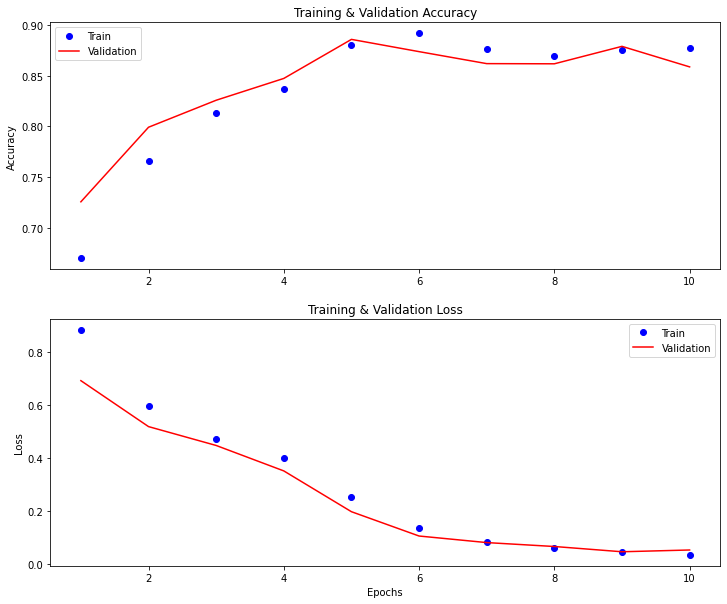

In [40]:
plot_performance(history_bidi_gru)

# Comparison
* Tradeoff GRU
  * Less Memory (Fewer) Parameters
  * Faster Training Time
  * Lower Accuracy
* Bidirectional was a big boost - definitely consider using it
* Deeper networks require longer training time

In [41]:
results_df

,Accuracy,Time,Parameters
LSTM,0.958914,100.166202,205324.0
LSTM DEEP,0.952629,122.978050,336908.0
LSTM BIDI,0.985400,131.010381,343052.0
GRU,0.893857,94.816122,155148.0
GRU DEEP,0.859971,113.809759,254220.0
GRU BIDI,0.858600,121.159214,258828.0


# Recap
* Introduction to seq2seq using simple example (adapted from keras.io)
* Comparison of GRU and LSTM (visualizing tradeoff)
* Bidirectional layers and hyper-parameters
* Use of the RepeatVector layer